# Preparing working environnment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import dataset
data = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')
data = data[['uniq_id', 'product_category_tree', 'image']]

# Retrieving categories
df_categ = data['product_category_tree'].str.split(pat = '>>', expand = True)
df_categ[0] = df_categ[0].apply(lambda x: str(x)[2:] if str(x)[:2] == '["' else x)

for c in np.arange(0,7,1):
    df_categ[c] = df_categ[c].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '"]' else x)
    
data = data.join(df_categ.iloc[:,:2])
data.rename(columns = {0 : 'category', 1 : 'subcategory'}, inplace = True)
data.drop(columns = 'product_category_tree', inplace = True)

# CNN

### Data preprocessing

In [3]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

save_path = '/content/drive/My Drive/DS_projet6/Edited_Images/'

# Creating image collection
for i in range(len(data)):
    img = load_img(save_path + data['image'][i], target_size=(300, 300))
    img = img_to_array(img)
    
    if i == 0:
        img_collec = img
    else:
        img_collec = np.append(img_collec, img)

img_collec = img_collec.reshape((len(data), 300, 300, 3))

In [4]:
# Train - test split
from sklearn.model_selection import train_test_split

y_ = pd.get_dummies(data['category'])
X_train, X_test, y_train, y_test = train_test_split(img_collec, y_, test_size = 0.3)

### Creating model

In [5]:
# Creating a new model
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras.models import Model
from keras import optimizers

# Retrieving VGG16 model without fully-connected layers
model = VGG16(weights="imagenet", 
              include_top=False, 
              input_shape=(300, 300, 3))
model.trainable = False

# Adding new fully-connected layers
x = model.output
x = Flatten()(x)
#x = Dense(300, activation = 'relu')(x)
x = Dense(200, activation = 'relu')(x)
x = Dense(100, activation = 'relu')(x)

# Predicting with 7 classes
pred = Dense(7, activation = 'softmax')(x)
new_model = Model(inputs=model.input, outputs=pred)
    
# Compiling
new_model.compile(loss="categorical_crossentropy", 
                  optimizer='adam', 
                  metrics=["accuracy"])

In [6]:
# Training model
new_model.fit(X_train, y_train, batch_size = 100, epochs = 10)

Epoch 1/10
8/8 [==============================] - 7s 818ms/step - loss: 45.2723 - accuracy: 0.3605
Epoch 2/10
8/8 [==============================] - 5s 581ms/step - loss: 6.6133 - accuracy: 0.7592
Epoch 3/10
8/8 [==============================] - 5s 592ms/step - loss: 1.9032 - accuracy: 0.8980
Epoch 4/10
8/8 [==============================] - 5s 602ms/step - loss: 0.4672 - accuracy: 0.9592
Epoch 5/10
8/8 [==============================] - 5s 615ms/step - loss: 0.2478 - accuracy: 0.9673
Epoch 6/10
8/8 [==============================] - 5s 616ms/step - loss: 0.0620 - accuracy: 0.9878
Epoch 7/10
8/8 [==============================] - 5s 624ms/step - loss: 0.0661 - accuracy: 0.9891
Epoch 8/10
8/8 [==============================] - 5s 633ms/step - loss: 4.8517e-04 - accuracy: 1.0000
Epoch 9/10
8/8 [==============================] - 5s 640ms/step - loss: 7.2432e-04 - accuracy: 1.0000
Epoch 10/10
8/8 [==============================] - 5s 651ms/step - loss: 1.9533e-04 - accuracy: 1.0000


In [7]:
# Model performance
from sklearn.metrics import classification_report
y_pred = new_model.predict(X_test)

print(classification_report(y_test.values.argmax(axis = 1), y_pred.argmax(axis = 1)))

              precision    recall  f1-score   support

           0       0.63      0.50      0.56        38
           1       0.63      0.89      0.74        37
           2       1.00      0.62      0.77        53
           3       0.52      0.82      0.64        45
           4       0.76      0.63      0.69        51
           5       0.85      0.68      0.76        41
           6       0.93      1.00      0.96        50

    accuracy                           0.74       315
   macro avg       0.76      0.74      0.73       315
weighted avg       0.77      0.74      0.74       315



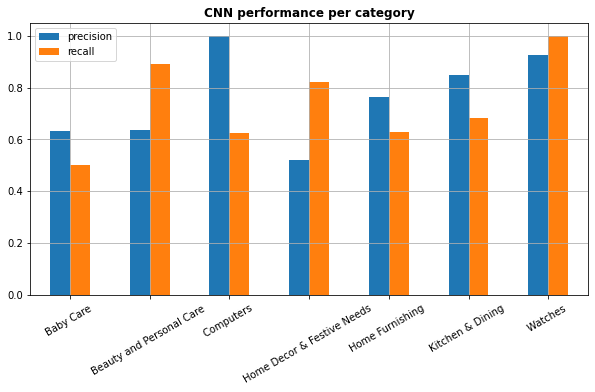

In [8]:
# Plotting scores
report = classification_report(y_test.values.argmax(axis = 1),
                               y_pred.argmax(axis = 1),
                               output_dict = True)

df_report = pd.DataFrame(report).iloc[:2,:7]
df_report.columns = y_.columns

df_report.T.plot(kind = 'bar', figsize = (10,5), rot = 30)
plt.title('CNN performance per category', fontweight = 'bold')
plt.grid(True)
plt.show()